# Cluster similar regions ~~on a hexgrid~~ based on Voronoi

In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import libpysal
import spopt
import h3
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance
from clustergram import Clustergram
from bokeh.io import output_notebook
from bokeh.plotting import show
from sklearn import cluster
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate

import preprocess_data

Retrieve building dataset and levels of clusters

In [2]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

Show area of interest (Central Europe sans Hungary)

<Axes: >

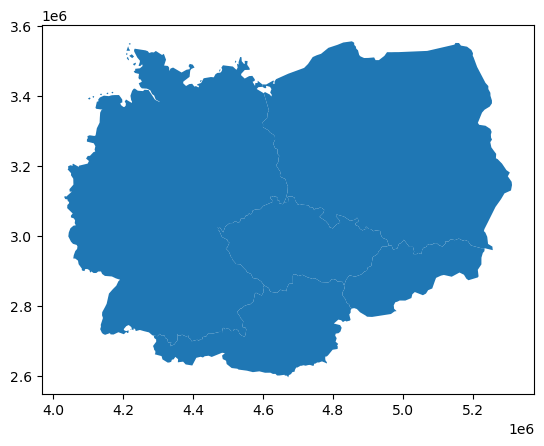

In [3]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi.plot()

# Hexes (old)

Hexify AOI

In [110]:
hexed = h3fy(aoi, resolution=3)

/home/dancejod/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'aoi_hexed')

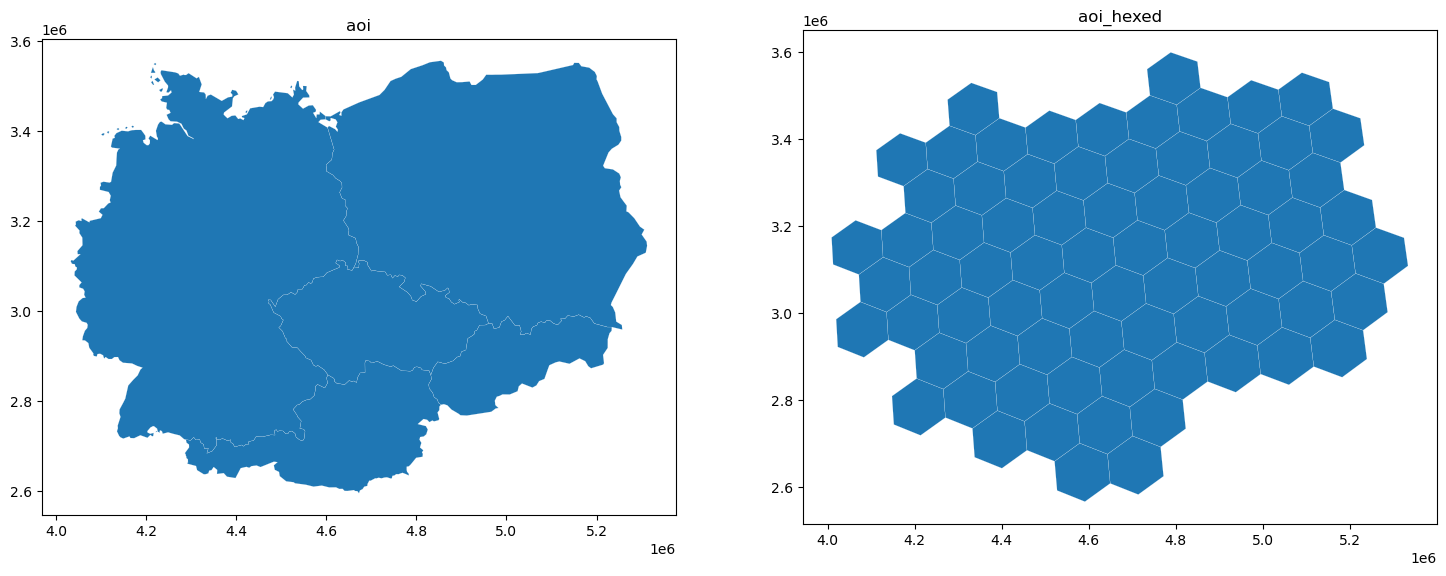

In [111]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

aoi.plot(ax=axs[0], linewidth=0.1, edgecolor='white')
hexed.plot(ax=axs[1], linewidth=0.1, edgecolor='white')

axs[0].set_title('aoi')
axs[1].set_title('aoi_hexed')

In [112]:
hexed

,geometry
hex_id,
831f52fffffffff,"POLYGON ((4948900.827 3247639.141, 5012283.856..."
831fabfffffffff,"POLYGON ((4322580.144 2865573.857, 4384564.554..."
831f88fffffffff,"POLYGON ((4400275.867 2642932.21, 4457929.792 ..."
831e2afffffffff,"POLYGON ((5108691.228 2942641.52, 5165268.677 ..."
831f55fffffffff,"POLYGON ((5152245.191 3530387.501, 5089637.06 ..."
...,...
831f8cfffffffff,"POLYGON ((4270425.806 2759403.495, 4332499.017..."
831f13fffffffff,"POLYGON ((4238285.619 3207119.268, 4242747.672..."
831e31fffffffff,"POLYGON ((4801848.552 2932456.398, 4794938.941..."


In [113]:
hexed.index.name = "NAME"

Join buildings dataset with the hexgrid on a specified hierarchy level

In [114]:
# def join_buildings_with_grid(level):
#     joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
#     data = joined.groupby("NAME")[level].value_counts().unstack().fillna(0)
#     data_norm = preprocess_data.normalize_building_counts(data)

#     return data_norm.T

In [115]:
joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
data = joined.groupby("NAME")["level_4"].value_counts().unstack().fillna(0)
X = data.values / data.sum(axis=1).values[:, np.newaxis]
X

array([[2.25510871e-01, 2.16836651e-01, 1.66838684e-01, ...,
        2.24960615e-03, 0.00000000e+00, 0.00000000e+00],
       [1.57586462e-01, 2.79330247e-01, 1.59256385e-01, ...,
        6.22117555e-03, 0.00000000e+00, 0.00000000e+00],
       [9.77363630e-02, 3.51186295e-02, 6.63049244e-02, ...,
        8.52698731e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.45269175e-01, 2.25244610e-01, 2.21318252e-01, ...,
        1.23166734e-02, 0.00000000e+00, 0.00000000e+00],
       [1.37583734e-01, 2.39451807e-01, 1.56201975e-01, ...,
        4.73605085e-02, 0.00000000e+00, 0.00000000e+00],
       [9.15245259e-02, 1.12642085e-01, 2.13284384e-01, ...,
        3.31146809e-02, 1.49580907e-04, 0.00000000e+00]], shape=(75, 16))

In [116]:
data

level_4,6,8,4,15,12,1,13,14,17,7,11,5,10,2,3,9
NAME,,,,,,,,,,,,,,,,
831e00fffffffff,227455.0,218706.0,168277.0,106557.0,81110.0,58583.0,52171.0,46884.0,14790.0,11274.0,8797.0,8223.0,3525.0,2269.0,0.0,0.0
831e01fffffffff,88328.0,156566.0,89264.0,42449.0,43560.0,35775.0,32493.0,43825.0,5047.0,5068.0,10492.0,4151.0,0.0,3487.0,0.0,0.0
831e04fffffffff,68176.0,24497.0,46251.0,24761.0,175930.0,129586.0,150540.0,2821.0,18004.0,49136.0,238.0,1662.0,0.0,5948.0,0.0,0.0
831e05fffffffff,140538.0,102209.0,88807.0,120873.0,276390.0,51442.0,318297.0,24808.0,25332.0,16422.0,20867.0,3050.0,76.0,1267.0,0.0,0.0
831e06fffffffff,88149.0,70683.0,191304.0,53473.0,64197.0,211170.0,98289.0,8502.0,13047.0,92769.0,5213.0,15476.0,0.0,57727.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831faafffffffff,379255.0,283339.0,531625.0,80329.0,28884.0,596102.0,60928.0,716.0,2818.0,50284.0,646.0,449597.0,77.0,30665.0,96.0,0.0
831fabfffffffff,265781.0,472250.0,243451.0,39197.0,20056.0,265408.0,112619.0,1816.0,1619.0,35090.0,308.0,190403.0,0.0,27666.0,0.0,0.0
831facfffffffff,214554.0,332673.0,326874.0,32160.0,11190.0,268749.0,32917.0,537.0,1366.0,26297.0,177.0,211256.0,0.0,18191.0,0.0,0.0


Build a contiguity graph and perform an example agglomerative clustering using Bray–Curtis distance

In [117]:
%%time
queen = graph.Graph.build_contiguity(hexed)
agg = cluster.AgglomerativeClustering(n_clusters=6, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete')
agg.fit(X)

CPU times: user 4.92 ms, sys: 91 μs, total: 5.01 ms
Wall time: 4.82 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 376 stored elements and shape (75, 75)>,
                        linkage='complete',
                        metric=<function braycurtis at 0x70067a8f20c0>,
                        n_clusters=6)

In [118]:
hexed[['geometry']].explore(agg.labels_, categorical=True, tiles="CartoDB Positron")

Try different numbers of clusters and create a clustergram

In [119]:
clusters = range(1,17)
labels_dict = {}

for k in clusters:
    labels_dict[k] = cluster.AgglomerativeClustering(n_clusters=k, connectivity=queen.sparse, metric=distance.braycurtis, linkage='complete').fit_predict(X)
labels = pd.DataFrame(labels_dict)
labels

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,1,1,1,4,4,4,4,4,1,1,0,0,0,2,2
1,0,0,0,0,1,1,1,0,2,2,0,1,1,1,1,0
2,0,0,0,0,1,1,1,0,2,2,0,11,11,11,11,11
3,0,0,0,0,1,1,1,0,8,8,8,8,8,8,8,8
4,0,1,1,1,4,4,4,4,4,1,1,0,0,0,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0,0,0,0,1,1,1,0,2,2,0,1,1,1,1,0
71,0,0,0,0,0,0,0,1,1,0,4,4,4,4,4,4
72,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,1
73,0,0,0,3,3,3,3,7,7,7,7,7,7,7,7,7


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

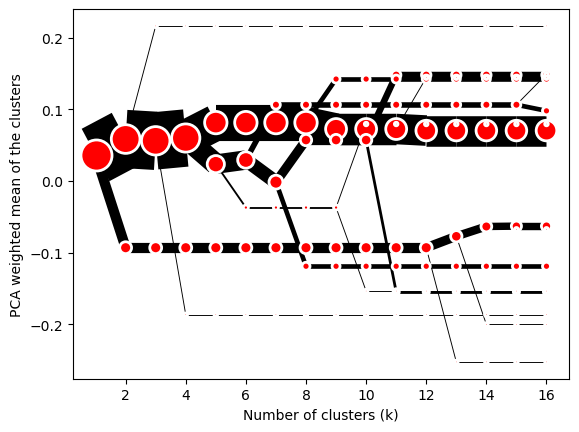

In [120]:
cgram = Clustergram.from_data(X, labels)
cgram.plot()

In [121]:
output_notebook()

Loading BokehJS ...

In [122]:
fig = cgram.bokeh()
show(fig)

Plot clusterized hexagons

In [123]:
def plot_cluster_maps(show_borders=False):
    fig, axs = plt.subplots(figsize=(15,10), nrows=4, ncols=4)
    axs = axs.flatten()
    
    for cluster, ax in zip(labels, axs):
        if show_borders:
            aoi.boundary.plot(ax=ax, color="maroon")
        hexed[["geometry"]].plot(labels[cluster].to_numpy(), ax=ax, categorical=True, cmap='tab20')
        ax.set_title(f"Number of clusters: {cluster}")
    
    plt.tight_layout()

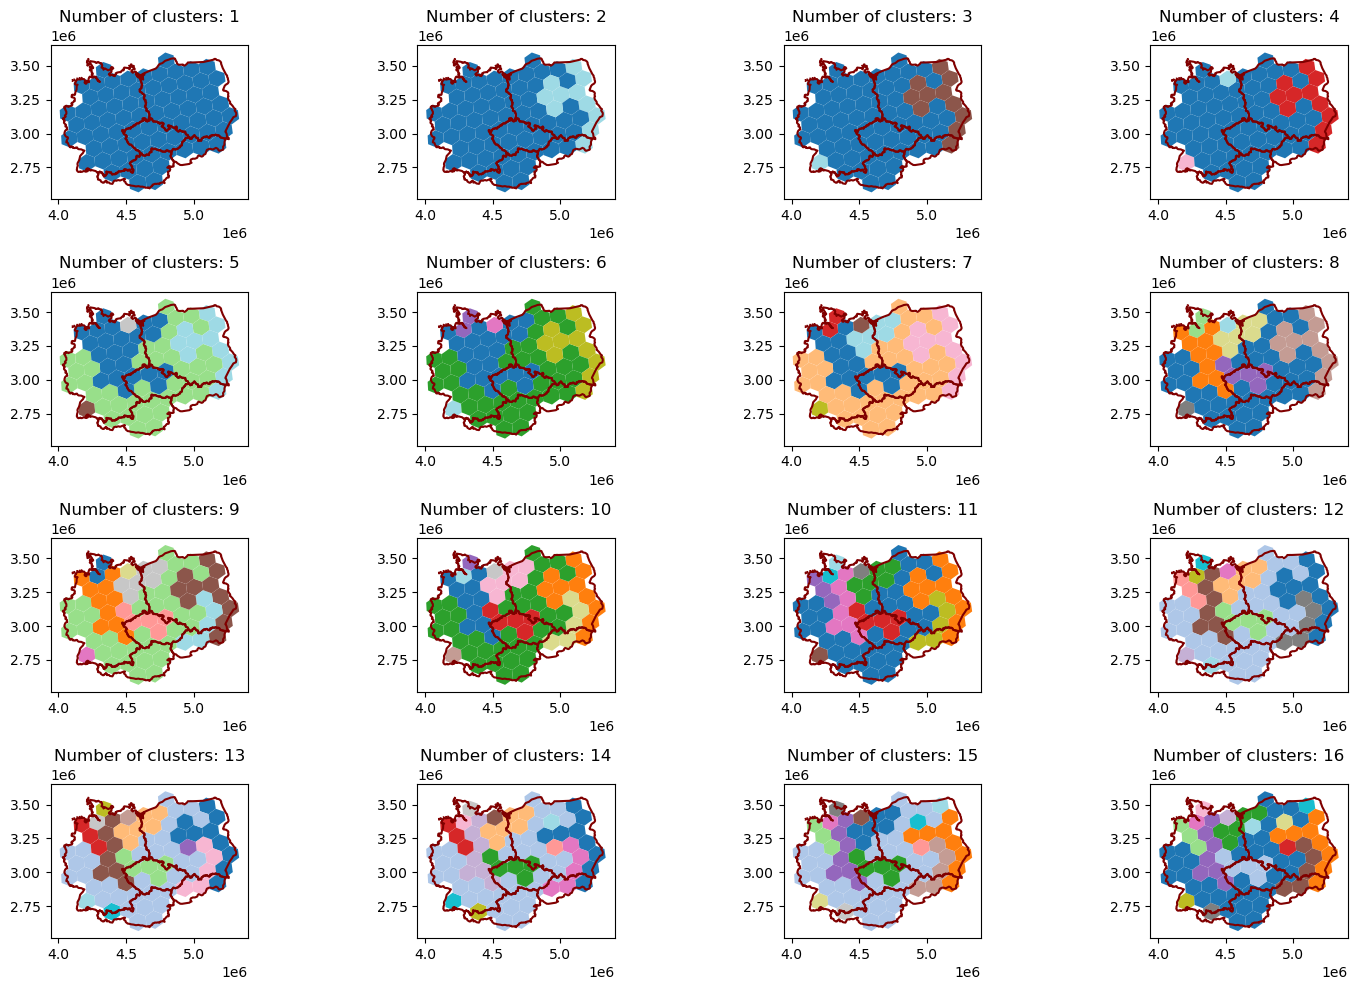

In [124]:
plot_cluster_maps(show_borders=True)

# Triangulation & Voronoi

Retrieve FUAs

In [4]:
fuas = gpd.read_file('/data/uscuni-ulce/boundaries_of_change/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
fuas

,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry
0,1.0,1.0,5959,Herat,1.0,AFG,Afghanistan,139.0,60.0,888811.175807,844574.564331,44236.611476,"MULTIPOLYGON (((5529000 4155000, 5531000 41550..."
1,192.0,1.0,5964,Guzarah,1.0,AFG,Afghanistan,32.0,16.0,169489.573231,160204.260864,9285.312366,"MULTIPOLYGON (((5541000 4139000, 5542000 41390..."
2,354.0,1.0,5968,Shindand,0.0,AFG,Afghanistan,12.0,12.0,147553.403870,147553.403870,0.000000,"MULTIPOLYGON (((5573000 4030000, 5574000 40300..."
3,505.0,1.0,5970,Qala i Naw,0.0,AFG,Afghanistan,3.0,3.0,79809.722656,79809.722656,0.000000,"MULTIPOLYGON (((5592000 4221000, 5590000 42210..."
4,648.0,1.0,5973,Farah,1.0,AFG,Afghanistan,32.0,16.0,131508.797060,122843.460327,8665.336733,"MULTIPOLYGON (((5607000 3923000, 5608000 39230..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9026,1739.0,1.0,4191,Triangle,0.0,ZWE,Zimbabwe,5.0,5.0,61859.251465,61859.251465,0.000000,"MULTIPOLYGON (((3023000 -2577000, 3021000 -257..."
9027,1908.0,1.0,4206,Glenclova,0.0,ZWE,Zimbabwe,4.0,4.0,158476.038086,158476.038086,0.000000,"MULTIPOLYGON (((3033000 -2449000, 3032000 -244..."
9028,2062.0,1.0,4222,Bindura,1.0,ZWE,Zimbabwe,54.0,16.0,109737.644325,74992.162598,34745.481728,"MULTIPOLYGON (((3053000 -2126000, 3054000 -212..."
9029,2137.0,1.0,4236,Marondera,1.0,ZWE,Zimbabwe,23.0,12.0,61332.544647,52538.743042,8793.801605,"MULTIPOLYGON (((3067000 -2235000, 3065000 -223..."


In [5]:
target_countries = ['DEU', 'CZE', 'AUT', 'POL', 'SVK']

In [6]:
fuas = fuas[fuas.Cntry_ISO.isin(target_countries)]
fuas = fuas.to_crs(epsg=3035)
#fuas.explore()

In [7]:
triangulation = graph.Graph.build_triangulation(fuas.centroid, method="gabriel", )

In [8]:
#triangulation.explore(fuas.centroid)

Code from `05_cities.ipynb`

In [9]:
%%time
regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')
mapping = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
results = []

for region_id in regions.index:
    
    region_buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_v10.pq')
    
    # assign polygons to only one fua
    inp, res = region_buildings.sindex.query(fuas.geometry, predicate='intersects')
    # polygons should be assigned to only one fua
    duplicated = pd.Series(res).duplicated()
    inp = inp[~duplicated]
    res = res[~duplicated]
    
    # keep only fua buildings and record  fua 'country', 'city', 'population'
    region_buildings = region_buildings.iloc[res]
    region_buildings.loc[:, ['city', 'country', 'population']] = fuas.iloc[inp, [3, 5, 9]].values

    results.append(region_buildings)

all_fua_buildings = pd.concat(results, ignore_index=True)

CPU times: user 1min 44s, sys: 8.18 s, total: 1min 53s
Wall time: 1min 45s


In [10]:
level = 7
subset = all_fua_buildings[['country', 'city', 'final_without_noise']]
    
if level < 7:
    subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())


res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
res = res.unstack(-1).fillna(0).astype(int)

# normalise based on counts
# note: normalisation can be based on building area too
X = res.values / res.sum(axis=1).values[:, np.newaxis]

In [11]:
X

array([[0.00416972, 0.00747479, 0.0188178 , ..., 0.        , 0.        ,
        0.        ],
       [0.01270188, 0.00740242, 0.03581763, ..., 0.00338156, 0.00154778,
        0.0044751 ],
       [0.01198964, 0.00763254, 0.02885436, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01243708, 0.02860529, 0.00623317, ..., 0.00103886, 0.00185825,
        0.        ],
       [0.01163287, 0.00616433, 0.00758029, ..., 0.00986292, 0.00939907,
        0.0064817 ],
       [0.0067825 , 0.01735432, 0.0058654 , ..., 0.009302  , 0.00321488,
        0.00287223]], shape=(136, 110))

In [12]:
res

final_without_noise   1     2     3     4     5     6    7    8    9    10   \
country city                                                                  
AUT     Graz          733  1314  3308   842  1905   654    0    0    0  272   
        Innsbruck     755   440  2129   631   742   263    0    0    0    0   
        Klagenfurt    787   501  1894  1136   450   271    0    0    0    0   
        Linz         2342  1651  2557  1702   900  1298    0    0    0  364   
        Salzburg     1121   776  1725  1179   770    99    0    0    0  140   
...                   ...   ...   ...   ...   ...   ...  ...  ...  ...  ...   
SVK     Bratislava   3054  6101  2788  1727   951  3116   70    0    0  359   
        Košice       2727  1317   905   564    41   608    0    0    0   90   
        Prešov        850  1955   426   300   239   250    0    0    0    4   
        Trnava        953   505   621   581   235   533  124    0    0  134   
        Žilina        673  1722   582   270   500  1044    0    0    0   86   

final_without_noise  ...   101  102  103  104   105   106   107  108   109  \
country city         ...                                                     
AUT     Graz         ...   776  128  478   19   512   432  1493    0     0   
        Innsbruck    ...   156   21  315    0   335   813  3318  201    92   
        Klagenfurt   ...   201   16    0    0   381   358  1577    0     0   
        Linz         ...  1594  339  507  138   477   680  2047   74     0   
        Salzburg     ...   909  136  680    0  1257   395  2181   87     0   
...                  ...   ...  ...  ...  ...   ...   ...   ...  ...   ...   
SVK     Bratislava   ...  2196  652  316  457   225  2535  2867  493  2176   
        Košice       ...   541  464   98  278   122   613   342    0   270   
        Prešov       ...    41    0   35   52     2   307   383   71   127   
        Trnava       ...   281   63    0  222   194   733   288  808   770   
        Žilina       ...   280  284    0    0    33   528   153  923   319   

final_without_noise   110  
country city               
AUT     Graz            0  
        Innsbruck     266  
        Klagenfurt      0  
        Linz            0  
        Salzburg        0  
...                   ...  
SVK     Bratislava   1698  
        Košice         12  
        Prešov          0  
        Trnava        531  
        Žilina        285  

[136 rows x 110 columns]

In [13]:
%%time
agg = cluster.AgglomerativeClustering(n_clusters=20, connectivity=triangulation.sparse, metric=distance.braycurtis, linkage='single')
agg.fit(X)

CPU times: user 5.38 ms, sys: 10 μs, total: 5.39 ms
Wall time: 5.57 ms


AgglomerativeClustering(connectivity=<Compressed Sparse Row sparse array of dtype 'float64'
	with 548 stored elements and shape (136, 136)>,
                        linkage='single',
                        metric=<function braycurtis at 0x7598926ee160>,
                        n_clusters=20)

<Axes: >

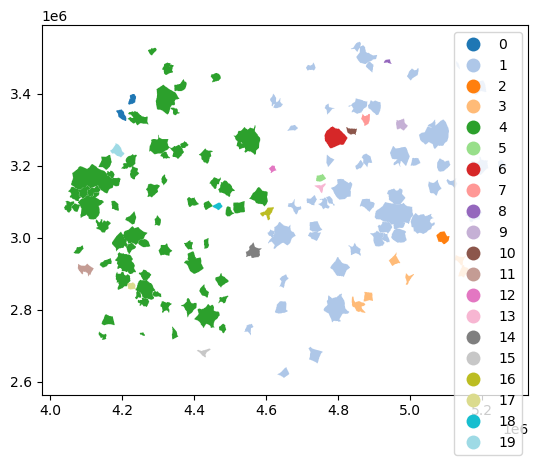

In [15]:
fuas.plot(column=agg.labels_, categorical=True, cmap="tab20", legend=True)

# Cluster variants

In [16]:
from spopt.region import SA3, AZP, MaxPHeuristic

In [335]:
df = pd.DataFrame(X, index=fuas.index)

In [351]:
df

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
252,0.004170,0.007475,0.018818,0.004790,0.010837,0.003720,0.000000,0.0,0.0,0.001547,...,0.004414,0.000728,0.002719,0.000108,0.002913,0.002457,0.008493,0.000000,0.000000,0.000000
253,0.012702,0.007402,0.035818,0.010616,0.012483,0.004425,0.000000,0.0,0.0,0.000000,...,0.002624,0.000353,0.005299,0.000000,0.005636,0.013678,0.055821,0.003382,0.001548,0.004475
254,0.011990,0.007633,0.028854,0.017307,0.006856,0.004129,0.000000,0.0,0.0,0.000000,...,0.003062,0.000244,0.000000,0.000000,0.005804,0.005454,0.024025,0.000000,0.000000,0.000000
255,0.017096,0.012052,0.018666,0.012424,0.006570,0.009475,0.000000,0.0,0.0,0.002657,...,0.011636,0.002475,0.003701,0.001007,0.003482,0.004964,0.014943,0.000540,0.000000,0.000000
256,0.015428,0.010680,0.023740,0.016226,0.010597,0.001362,0.000000,0.0,0.0,0.001927,...,0.012510,0.001872,0.009358,0.000000,0.017299,0.005436,0.030016,0.001197,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7673,0.014625,0.029216,0.013351,0.008270,0.004554,0.014922,0.000335,0.0,0.0,0.001719,...,0.010516,0.003122,0.001513,0.002188,0.001077,0.012139,0.013729,0.002361,0.010420,0.008131
7674,0.026708,0.012899,0.008864,0.005524,0.000402,0.005955,0.000000,0.0,0.0,0.000881,...,0.005299,0.004544,0.000960,0.002723,0.001195,0.006004,0.003350,0.000000,0.002644,0.000118
7675,0.012437,0.028605,0.006233,0.004390,0.003497,0.003658,0.000000,0.0,0.0,0.000059,...,0.000600,0.000000,0.000512,0.000761,0.000029,0.004492,0.005604,0.001039,0.001858,0.000000
7676,0.011633,0.006164,0.007580,0.007092,0.002869,0.006506,0.001514,0.0,0.0,0.001636,...,0.003430,0.000769,0.000000,0.002710,0.002368,0.008947,0.003515,0.009863,0.009399,0.006482


In [336]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=6, extraction='leaf', metric=distance.braycurtis, linkage='single')
clusterer.solve()

<Axes: >

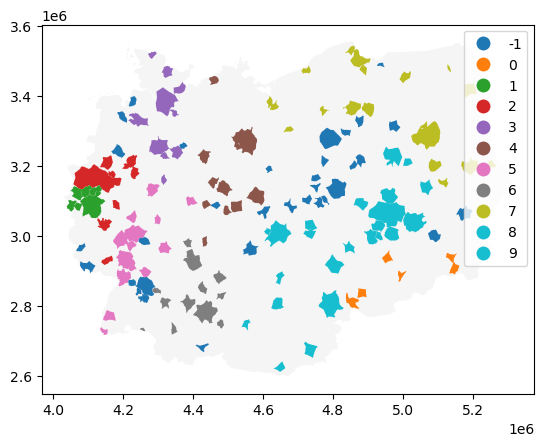

In [337]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [338]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])
dissolved_fuas

,geometry,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015
0,"MULTIPOLYGON (((4842518.337 2830446.923, 48434...",163.0,1.0,3069,Bratislava,1.0,SVK,Slovakia,833.0,117.0,5.233605e+05,3.520020e+05,1.713585e+05
1,"POLYGON ((4074251.872 3092044.357, 4081731.62 ...",44.0,2.0,2245;2235,Heerlen,1.0,DEU,Germany,532.0,111.0,5.445587e+05,2.931652e+05,2.513935e+05
2,"MULTIPOLYGON (((4170291.876 2937202.583, 41700...",536.0,2.0,2276;2353,Dortmund,1.0,DEU,Germany,6303.0,1423.0,5.837625e+06,3.691645e+06,2.145980e+06
3,"MULTIPOLYGON (((4320015.343 3168741.492, 43199...",2877.0,3.0,2422;2431;2439,Bremen,1.0,DEU,Germany,1287.0,200.0,8.688432e+05,5.063416e+05,3.625016e+05
4,"MULTIPOLYGON (((4440531.462 2981994.476, 44404...",4553.0,1.0,2748,Magdeburg,1.0,DEU,Germany,840.0,78.0,3.382579e+05,1.937056e+05,1.445523e+05
5,"MULTIPOLYGON (((4139905.981 2736307.79, 413980...",2227.0,1.0,2392,Basel,1.0,DEU,Germany,266.0,31.0,1.756185e+05,7.529602e+04,1.003225e+05
6,"MULTIPOLYGON (((4260717.029 2733681.951, 42606...",3906.0,1.0,2549,Constance,1.0,DEU,Germany,83.0,22.0,8.029963e+04,5.825741e+04,2.204223e+04
7,"MULTIPOLYGON (((4682007.272 3309647.3, 4682926...",140.0,2.0,2907;2914,Szczecin,1.0,POL,Poland,684.0,97.0,4.862453e+05,3.258754e+05,1.603699e+05
8,"MULTIPOLYGON (((4657922.763 2635256.217, 46578...",199.0,1.0,2885,Salzburg,1.0,AUT,Austria,368.0,46.0,2.610628e+05,1.400522e+05,1.210107e+05
9,"MULTIPOLYGON (((4912648.763 3016122.111, 49126...",1389.0,1.0,3120,Ostrava,1.0,CZE,CzechRepublic,1043.0,72.0,5.502749e+05,1.865196e+05,3.637554e+05


In [339]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=2000, segment=1000)

/tmp/ipykernel_24287/777305694.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=2000, segment=1000)


In [340]:
voronoi

,geometry
0,"POLYGON ((4844735.846 2771932.401, 4844053.518..."
1,"POLYGON ((4054193.148 3143264.983, 4054750.837..."
2,"POLYGON ((4081651.428 2847616.083, 4042167.23 ..."
3,"POLYGON ((4311130.223 3142154.564, 4309142.95 ..."
4,"POLYGON ((4431316.324 2953634.157, 4415875.787..."
5,"POLYGON ((4081651.428 2847616.083, 4092088.681..."
6,"POLYGON ((4214799.749 2627824.489, 4204171.829..."
7,"POLYGON ((5217038.465 3051502.579, 5216126.303..."
8,"POLYGON ((4515629.662 2622061.758, 4516059.07 ..."
9,"POLYGON ((5007437.754 2952837.581, 5001924.633..."


<Axes: >

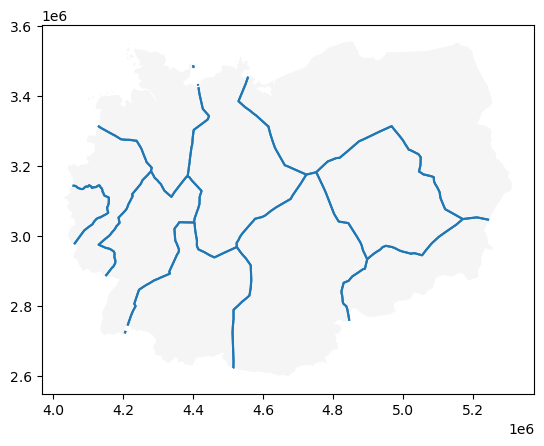

In [341]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [347]:
optimal_boundaries

,geometry
6,"MULTIPOLYGON (((4207566.664 2727876.895, 42088..."
0,"POLYGON ((4844053.518 2775339.55, 4844000.499 ..."
8,"POLYGON ((4516059.07 2641030.301, 4513203.964 ..."
5,"POLYGON ((4152108.487 2887321.155, 4158334.936..."
1,"POLYGON ((4056411.867 3143080.845, 4059895.758..."
2,"POLYGON ((4085116.199 3009699.865, 4089117.148..."
9,"POLYGON ((5001924.633 2954128.74, 4997328.42 2..."
4,"MULTIPOLYGON (((4415875.787 2960830.404, 44157..."
7,"POLYGON ((5216126.303 3051686.032, 5211888.642..."
3,"MULTIPOLYGON (((4309142.95 3146015.014, 430841..."


In [348]:
bray_curtis_dist = distance.pdist(optimal_boundaries, metric='braycurtis')
    

ValueError: Unsupported dtype object

In [ ]:
bray_curtis_matrix = distance.squareform(bray_curtis_dist)
    bray_curtis_df = pd.DataFrame(bray_curtis_matrix, index=count_table.T.columns, columns=count_table.T.columns)

In [115]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=6, extraction='eom', metric=distance.braycurtis, linkage='average')
clusterer.solve()

<Axes: >

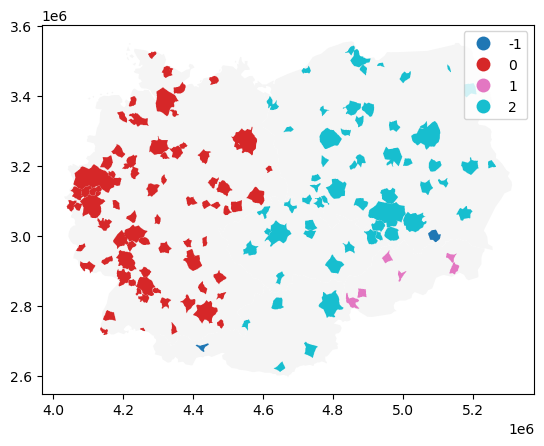

In [116]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [117]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [118]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)

/tmp/ipykernel_24287/271934043.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)


<Axes: >

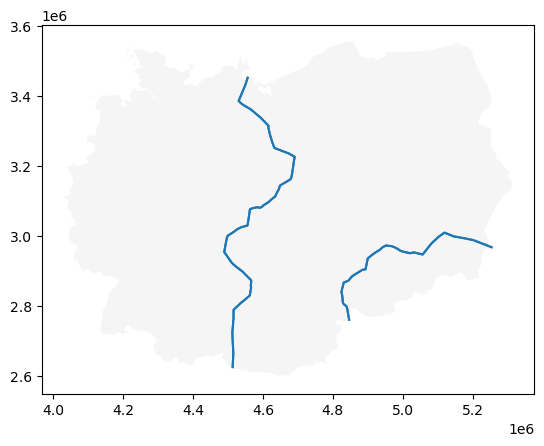

In [119]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [250]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=13, extraction='leaf', metric=distance.braycurtis, linkage='single')
clusterer.solve()

<Axes: >

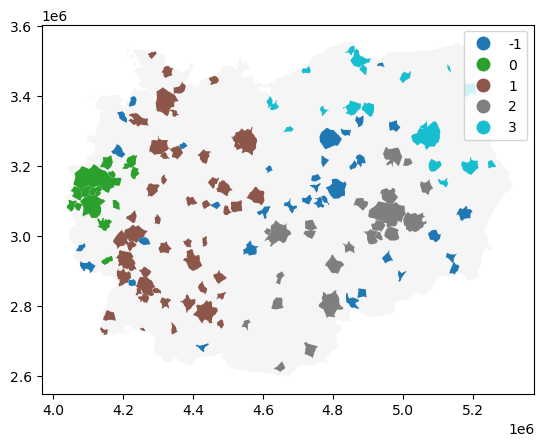

In [251]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [252]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [253]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)

/tmp/ipykernel_24287/271934043.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=1000, segment=500)


<Axes: >

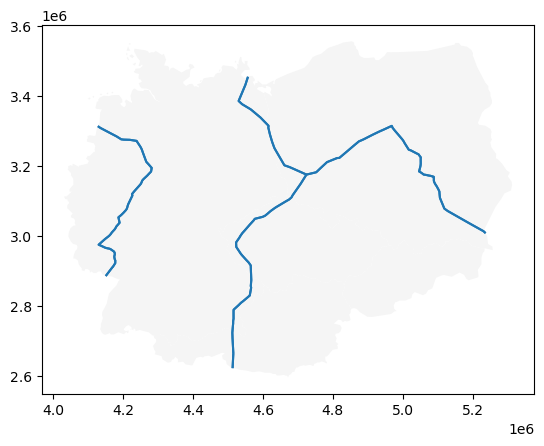

In [254]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [272]:
clusterer = AZP(df, triangulation.to_W(), attrs_name=df.columns, n_clusters=4)
clusterer.solve()

<Axes: >

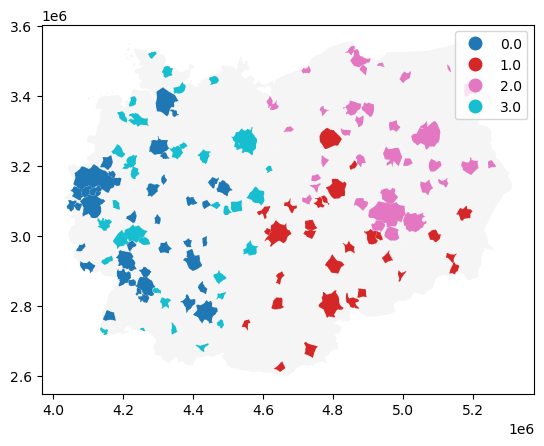

In [273]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [274]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)

In [275]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)

/tmp/ipykernel_24287/2257978305.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)


<Axes: >

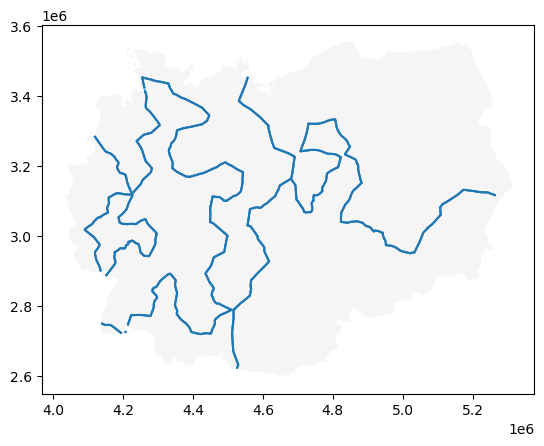

In [277]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

In [278]:
clusterer = SA3(df, triangulation, attrs_name=df.columns.values, min_cluster_size=10, extraction='leaf', metric=distance.braycurtis, linkage='single')
clusterer.solve()

<Axes: >

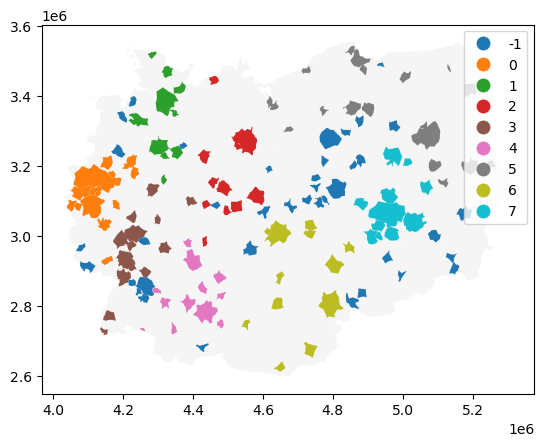

In [279]:
ax = aoi.plot(color="whitesmoke")
fuas.plot(ax=ax, column=clusterer.labels_, categorical=True, legend=True)

In [280]:
dissolved_fuas = fuas.dissolve(by=clusterer.labels_)
dissolved_fuas = dissolved_fuas.drop([-1])

In [281]:
voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)

/tmp/ipykernel_24287/2257978305.py:1: FutureWarning: The 'as_gdf' parameter currently defaults to True but will default to False in a future release. Set it explicitly to avoid this warning.
  voronoi =  libpysal.cg.voronoi_frames(dissolved_fuas, return_input=False, shrink=500, segment=100)


<Axes: >

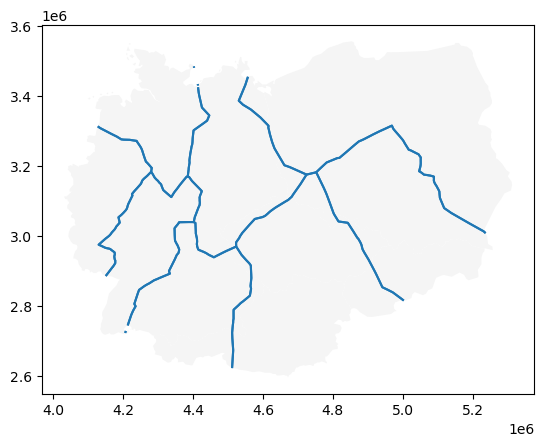

In [282]:
optimal_boundaries = gpd.clip(voronoi, aoi)
ax = optimal_boundaries.boundary.difference(optimal_boundaries.union_all().boundary).plot()
aoi.plot(ax=ax, color="whitesmoke")

## Silhouettes

In [361]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

In [364]:
cnt_table = preprocess_data.get_building_counts_per_region(buildings, optimal_boundaries.reset_index().rename(columns={"index":"NAME"}))

In [366]:
cnt_table_norm = preprocess_data.normalize_building_counts(cnt_table)

In [367]:
cnt_table_norm

level_4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
NAME,,,,,,,,,,,,,,,,,
0.0,0.054281,0.004888,0.000000,0.176159,0.007588,0.168147,0.011438,0.223147,0.000000,0.001719,0.017747,0.085492,0.069149,0.073922,0.091915,0.000000,0.014408
1.0,0.408014,0.051154,0.000022,0.142281,0.042198,0.097534,0.021141,0.153637,0.000000,0.000000,0.000000,0.005838,0.042541,0.001385,0.032229,0.000000,0.002025
2.0,0.218424,0.014458,0.000010,0.178005,0.096175,0.149963,0.031712,0.143313,0.000000,0.000000,0.000077,0.015911,0.106630,0.001127,0.040341,0.000000,0.003852
3.0,0.109376,0.012925,0.000045,0.167714,0.078144,0.199230,0.038539,0.150830,0.000152,0.001650,0.009496,0.022249,0.138897,0.023302,0.041062,0.000009,0.006379
4.0,0.118254,0.026358,0.000008,0.204160,0.018533,0.132799,0.029281,0.161411,0.000034,0.000875,0.002721,0.042967,0.112810,0.048133,0.088952,0.000000,0.012704
5.0,0.262659,0.023394,0.000042,0.193343,0.131201,0.132913,0.014944,0.165285,0.000000,0.000024,0.000121,0.008803,0.030511,0.001041,0.032942,0.000010,0.002768
6.0,0.131053,0.008989,0.000025,0.159759,0.126965,0.154442,0.028576,0.219306,0.000000,0.000000,0.001322,0.022822,0.115162,0.001364,0.028457,0.000000,0.001757
7.0,0.038477,0.001809,0.000000,0.118406,0.002301,0.035264,0.007621,0.211948,0.000000,0.015309,0.078776,0.184881,0.162598,0.085019,0.029261,0.000000,0.028328
8.0,0.108628,0.018841,0.000000,0.121255,0.008396,0.099650,0.051971,0.057037,0.000000,0.000000,0.001766,0.130846,0.343324,0.002189,0.042816,0.000000,0.013281


In [358]:
a

,NAME,NOTES,geometry
0,Austria,None,"MULTIPOLYGON (((4355225.354 2715902.995, 43542..."
1,Czechia,None,"MULTIPOLYGON (((4623550.104 3113763.447, 46305..."
2,Germany,None,"MULTIPOLYGON (((4355225.354 2715902.995, 43557..."
3,Poland,None,"MULTIPOLYGON (((4922206.626 3502100.945, 49317..."
4,Slovakia,None,"MULTIPOLYGON (((5029148.516 2968082.296, 50325..."
